In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import unicodedata
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [71]:
#Read and cleanup
df = pd.read_csv('data/movie_all_genre.csv')

indexes = df[ df['genre'] == 'News'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Game-Show'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Reality-TV'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Talk-Show'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Short'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Biography'].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'] == 'Film-Noir'].index
df.drop(indexes, inplace=True)
df.drop_duplicates(subset='movie', inplace=True)


In [84]:
df['genre_id'] = df['genre'].factorize()[0]
category_id_df = df[['genre', 'genre_id']].drop_duplicates().sort_values('genre_id')
categories = np.unique(df['genre'].values)
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['genre_id', 'genre']].values)
df.head()

Musical


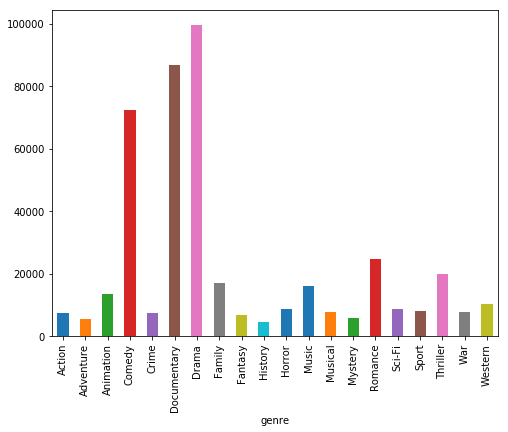

In [73]:
#Majority of movies are comedy, documentary or drama apaprently.

fig = plt.figure(figsize=(8,6))
df.groupby('genre').movie.count().plot.bar(ylim=0)
plt.show()

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
tfidf = TfidfVectorizer(lowercase = True, sublinear_tf=True, norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.movie)
labels = df.genre_id
features.shape

(437419, 773826)

In [76]:
from sklearn.feature_selection import chi2
N = 2
for movie, genre_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == genre_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(movie))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Action':
  . Most correlated unigrams:
. wwe
. narcos
  . Most correlated bigrams:
. la mafia
. de michoacã
# 'Adventure':
  . Most correlated unigrams:
. bound
. bondage
  . Most correlated bigrams:
. dangerous diva
. other tales
# 'Animation':
  . Most correlated unigrams:
. vesyolaya
. filminuto
  . Most correlated bigrams:
. doraemon nobita
. vesyolaya karusel
# 'Comedy':
  . Most correlated unigrams:
. comedy
. kri
  . Most correlated bigrams:
. the fable
. kri kri
# 'Crime':
  . Most correlated unigrams:
. tod
. mord
  . Most correlated bigrams:
. maigret et
. bienzle und
# 'Documentary':
  . Most correlated unigrams:
. playboy
. making
  . Most correlated bigrams:
. the making
. making of
# 'Drama':
  . Most correlated unigrams:
. show
. woman
  . Most correlated bigrams:
. the making
. making of
# 'Family':
  . Most correlated unigrams:
. porky
. hare
  . Most correlated bigrams:
. the pooh
. winnie the
# 'Fantasy':
  . Most correlated unigrams:
. andersens
. eventyrlige
  .

In [132]:
#Naive Bayes
x_train, x_val, y_train, y_val = train_test_split(df['movie'], df['genre'], random_state = 0)
count_vect = CountVectorizer()
x_counts = count_vect.fit_transform(x_train)
tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(x_counts)
clf = MultinomialNB().fit(x_tfidf, y_train)

In [134]:
print(clf.predict_proba(count_vect.transform(["The killer"])))
probs = clf.predict_proba(count_vect.transform(["The killer"]))
for prob in probs:
    
print(clf.predict(count_vect.transform(["'Crocodile' Dundee II"])))
print(clf.predict(count_vect.transform(["Mystery Science Theater"])))
print(clf.predict(count_vect.transform(["Bee Movie"])))
print(clf.predict(count_vect.transform(["Ants"])))
print(clf.predict(count_vect.transform(["Zombie"])))
print(clf.predict(count_vect.transform(["Berlins Brewery"])))
print(clf.predict(count_vect.transform(["Bubble Kid"])))

[[1.22920367e-03 4.83702396e-04 8.31710087e-04 2.07212785e-01
  9.10427901e-04 3.82205779e-01 2.58050900e-01 2.71211678e-03
  6.26734101e-04 3.26641778e-04 1.59983902e-02 3.89701466e-03
  2.19376187e-04 9.82505434e-04 3.28286810e-03 3.37737699e-03
  8.40625633e-04 1.10668276e-01 6.31670732e-04 5.51189588e-03]]
[1.22920367e-03 4.83702396e-04 8.31710087e-04 2.07212785e-01
 9.10427901e-04 3.82205779e-01 2.58050900e-01 2.71211678e-03
 6.26734101e-04 3.26641778e-04 1.59983902e-02 3.89701466e-03
 2.19376187e-04 9.82505434e-04 3.28286810e-03 3.37737699e-03
 8.40625633e-04 1.10668276e-01 6.31670732e-04 5.51189588e-03]
['Documentary']
['Documentary']
['Documentary']
['Documentary']
['Horror']
['Drama']
['Comedy']


In [98]:
from sklearn.svm import LinearSVC

tfidf = TfidfVectorizer(lowercase = True, sublinear_tf=True, norm='l2', ngram_range=(1, 2), strip_accents='unicode')
features = tfidf.fit_transform(df.movie)
x_train, x_val, y_train, y_val, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.30, random_state=5000)
#unweighted:
svc = LinearSVC()
labels = df.genre_id
svc.fit(x_train, y_train)
print("unweighted:")
print(svc.score(x_val, y_val))

#weighted:
svc_w = LinearSVC(class_weight='balanced')
print("weighted")
svc_w.fit(x_train, y_train)
print(svc_w.score(x_val, y_val))


unweighted:
0.37572584701202505
weighted
0.32710743297822076


In [99]:
def getsvcprediction(model, title):
    print(title)
    return id_to_category[model.predict(tfidf.transform([title]))[0]]

In [135]:
#print(x_train)
print(getsvcprediction(svc, "Crocodile Dundee"))
print(getsvcprediction(svc, "Bee Movie"))
print(getsvcprediction(svc, "Toy Story"))
print(getsvcprediction(svc, "Zombies Return"))
print(getsvcprediction(svc, "Blade Runner"))
print(getsvcprediction(svc, "The Tower"))
print(getsvcprediction(svc, "Berlins Brewery"))
print(getsvcprediction(svc, "Bubble Kid"))
print(getsvcprediction(svc, "Overlord"))

print()
print(getsvcprediction(svc_w, "Crocodile Dundee"))
print(getsvcprediction(svc_w, "Bee Movie"))
print(getsvcprediction(svc_w, "Toy Story"))
print(getsvcprediction(svc_w, "Zombies Return"))
print(getsvcprediction(svc_w, "Blade Runner"))
print(getsvcprediction(svc_w, "The Tower"))
print(getsvcprediction(svc_w, "Berlins Brewery"))
print(getsvcprediction(svc_w, "Bubble Kid"))
print(getsvcprediction(svc_w, "Overlord"))


Crocodile Dundee
Comedy
Bee Movie
Family
Toy Story
Family
Zombies Return
Horror
Blade Runner
Documentary
The Tower
Drama
Berlins Brewery
Documentary
Bubble Kid
Family
Overlord
Action

Crocodile Dundee
Comedy
Bee Movie
Family
Toy Story
Family
Zombies Return
Horror
Blade Runner
Sci-Fi
The Tower
Sci-Fi
Berlins Brewery
Music
Bubble Kid
Family
Overlord
Action


In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit_transform([(c,) for c in df.genre])
labels = mlb.classes_
print(labels)
print(labels.shape)

filter_length = 300
max_words = 5000
maxlen = 200

num_classes = len(np.unique(df.genre))
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df.movie)

def get_features(text_series):
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)

def prediction_to_label(prediction):
    tag_prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]

def classify_movies_conv1d():
    # create model
    model = Sequential()
    model.add(Embedding(max_words, 20, input_length=maxlen))
    model.add(Dropout(0.1))
    model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(20))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
    return model

def classify_movies_maxpool():
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'History' 'Horror' 'Music' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Sport' 'Thriller' 'War' 'Western']
(20,)


In [6]:
from sklearn.model_selection import train_test_split

x = get_features(df.movie)
y = mlb.fit_transform([(c,) for c in df.genre])
print(x.shape)
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)

(175850, 200)
(175850, 20)


In [8]:
grouped_genre = df.groupby('genre').size().reset_index(name='count')
most_common_genre = grouped_genre.nlargest(num_classes, columns="count")

most_common_genre['class_weight'] = len(df['genre']) / most_common_genre['count']

class_weight = {}
for index, label in enumerate(labels):
    class_weight[index] = most_common_genre[most_common_genre['genre'] == label]['class_weight'].values[0]

In [9]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D

callbacks = [
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

model = classify_movies()
model.summary()

import tensorflow as tf

history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 20)           100000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 20)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 300)          18300     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                6020      
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
Total params: 124,320
Trainable params: 124,320
Non-trainable params: 0
_________________________________________________________________
Trai

In [10]:
cnn_model = keras.models.load_model('model-conv1d.h5')
metrics = cnn_model.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

35170/35170 [==============================] - 4s 112us/step
loss: 0.1836053080151357
categorical_accuracy: 0.18146147284617573
